## ViT model on different test set

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import cv2 as cv
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers, models
from random import randint
import albumentations as A
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow.keras

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [6]:
import pandas as pd
import matplotlib
import cv2
import numpy as np
import keras
import albumentations
import tensorflow as tf
import os
import sklearn
import imblearn

# Print version numbers
print("Pandas version:", pd.__version__)
print("Matplotlib version:", matplotlib.__version__)
print("OpenCV version:", cv2.__version__)
print("NumPy version:", np.__version__)
print("Keras version:", keras.__version__)
print("Albumentations version:", albumentations.__version__)
print("TensorFlow version:", tf.__version__)
print("Scikit-learn version:", sklearn.__version__)
print("Imblearn version:", imblearn.__version__)


Pandas version: 2.2.2
Matplotlib version: 3.8.0
OpenCV version: 4.10.0
NumPy version: 1.26.4
Keras version: 2.15.0
Albumentations version: 1.4.20
TensorFlow version: 2.15.0
Scikit-learn version: 1.5.2
Imblearn version: 0.12.4


In [1]:
!pip install tensorflow==2.15.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 17.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 26.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 33.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 20.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 2.8 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.16.0
    Uninstalling wrapt-1.16.0:
      Successfully uninstalled wrapt-1.16.0
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.4.1
    Uninstalling ml-dtypes-0.4.1:
      Successfully uninstalled ml-dtypes-0.4.1
  Attempting uninstall: keras
    Found existing installation: keras 3.5.0
    Uninstalling keras-3.5.0:
      Successfully uninstalled keras-3.5.0
  Attempting uninstall: tensorboard
    Found existing installation

In [3]:
#mount my drive

from google.colab import drive

drive.mount ('/content/drive')

Mounted at /content/drive


In [4]:

!unzip "/content/drive/My Drive/Thesis/images_by_AR.zip" -d "/content"


Streaminguitvoer ingekort tot de laatste 5000 regels.
  inflating: /content/images_by_AR/2717/2717_hmi.M_720s.20180802_133600_TAI.3.magnetogram_224.png  
  inflating: /content/images_by_AR/2717/2717_hmi.M_720s.20180802_134800_TAI.3.magnetogram_224.png  
  inflating: /content/images_by_AR/2717/2717_hmi.M_720s.20180802_140000_TAI.3.magnetogram_224.png  
  inflating: /content/images_by_AR/2717/2717_hmi.M_720s.20180802_141200_TAI.3.magnetogram_224.png  
  inflating: /content/images_by_AR/2717/2717_hmi.M_720s.20180802_142400_TAI.3.magnetogram_224.png  
  inflating: /content/images_by_AR/2717/2717_hmi.M_720s.20180802_143600_TAI.3.magnetogram_224.png  
  inflating: /content/images_by_AR/2717/2717_hmi.M_720s.20180802_144800_TAI.3.magnetogram_224.png  
  inflating: /content/images_by_AR/2717/2717_hmi.M_720s.20180802_150000_TAI.3.magnetogram_224.png  
  inflating: /content/images_by_AR/2717/2717_hmi.M_720s.20180802_151200_TAI.3.magnetogram_224.png  
  inflating: /content/images_by_AR/2717/2717_h

In [7]:
#load in the split datasets from the EDA section

train = pd.read_csv('/content/drive/My Drive/Thesis/train_us_2.csv')
test = pd.read_csv('/content/drive/My Drive/Thesis/test_2.csv')
val = pd.read_csv('/content/drive/My Drive/Thesis/val_us_2.csv')


print (len(train))
print (len(val))
print (len(test))

76230
8972
97923


In [ ]:
# Example code to check for missing images
dir = '/content/images_by_AR/'
missing_images = [filename for filename in filenames if not os.path.exists(os.path.join(dir, filename))]
print(f"Missing images: {missing_images}")  # This will show you any missing images


Missing images: []


## Dataset creation

In [ ]:
#set up the augmentation pipeline
def augment (img):
  """Have the image augmented with random augmentation"""

  augmentations = A.Compose(
      [A.HorizontalFlip (p = 0.5),
       A.VerticalFlip(p=0.5),
       A.Rotate (limit=(-90,90), interpolation=cv.INTER_CUBIC, border_mode=cv.BORDER_REFLECT, p=0.5)]
  )

  augmented = augmentations(image=img)['image']

  return augmented

In [ ]:

import tensorflow as tf
import pandas as pd
import cv2
import numpy as np
import time

dir = '/content/images_by_AR/'

# Function to load and process images

def load_and_process_image(filename, label):
    # Decode the filename from bytes to string
    filename = filename.decode('utf-8')
    filename = os.path.join(dir, filename)
    # Read the image
    img = cv2.imread(filename)
    if img is None:
        raise ValueError(f"Image at {filename} not found.")

    # Convert image from BGR to RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    img = augment(img)

    img = img.astype(np.float32) / 255.0

    return img, label

# Create a tf.data.Dataset from the CSV
filenames = train['filename'].values
labels = train['class'].values

# Convert filenames and labels to TensorFlow Tensors
dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))

# Map the loading and processing function
def map_func(filename, label):
    img, label = load_and_process_image(filename.numpy(), label.numpy())
    return img, label

# Apply tf.py_function and explicitly set output shapes
dataset = dataset.map(
    lambda filename, label: tf.py_function(
        func=map_func, inp=[filename, label], Tout=[tf.float32, tf.int64]
    ),
    num_parallel_calls=tf.data.experimental.AUTOTUNE
)

def set_shapes(img, label):
    img.set_shape((224, 224, 3))  # Set the shape for the image
    label.set_shape(())  # Set the shape for the label (scalar)
    return img, label

dataset = dataset.map(set_shapes)

# Batch and prefetch the dataset for performance
dataset = dataset.batch(64).prefetch(tf.data.experimental.AUTOTUNE)

# Test the dataset for shape consistency
for images, labels in dataset.take(1):
    print ('batch fetched')


batch fetched


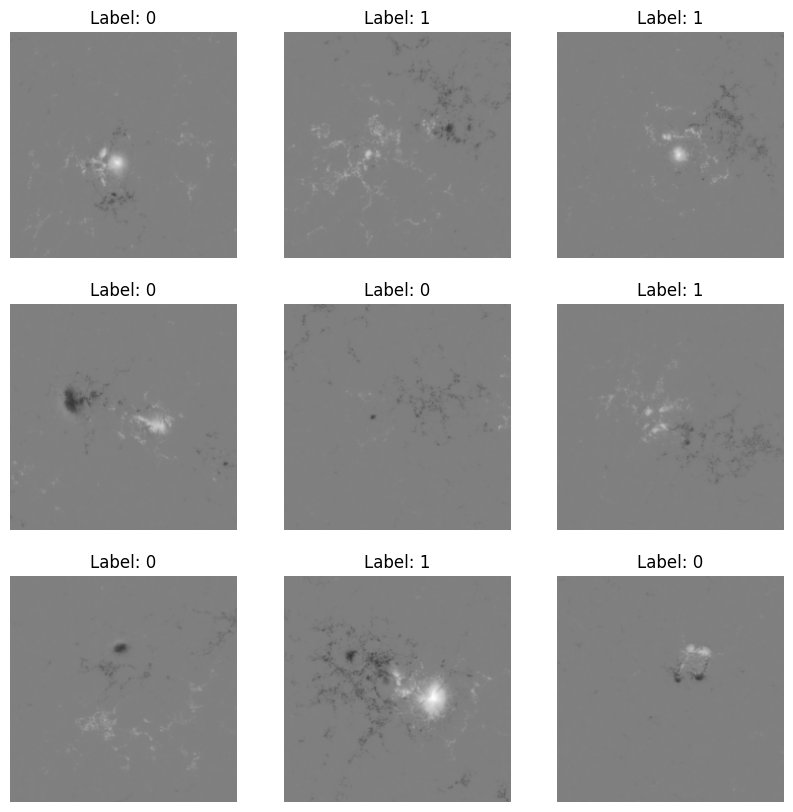

In [ ]:
import matplotlib.pyplot as plt

# Function to plot a grid of 9 images
def display_batch_of_images(images, labels):
    plt.figure(figsize=(10, 10))

    for i in range(9):  # Display the first 9 images
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        plt.title(f"Label: {labels[i].numpy()}")
        plt.axis("off")  # Hide axes

    plt.show()

# Fetch one batch of images and labels
for images, labels in dataset.take(1):
    # Since the dataset is batched, we take the first batch and display it
    display_batch_of_images(images, labels)
    break


In [ ]:
import tensorflow as tf
import pandas as pd
import cv2
import numpy as np
import time

dir = '/content/images_by_AR/'

#loading in images and preprocess them
def load_and_process_image_val(filename, label):
    filename = filename.decode('utf-8')
    filename = os.path.join(dir, filename)
    #image loading
    img = cv2.imread(filename)
    if img is None:
        raise ValueError(f"Image at {filename} not found.")

    #convert to rgb
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    #normalize the image to 0, 1
    img = img.astype(np.float32) / 255.0

    return img, label

#convert these filenames and labels to np arrays to pass to the map (), because the preprocessing functions need np arrays and not tensors
def map_func_val(filename, label):
    img, label = load_and_process_image_val(filename.numpy(), label.numpy())
    return img, label

#get the filenames and labels to use in the functions created above
filenames_val = val['filename'].values
labels_val = val['class'].values

#make the datasets (turns filenames and labels to tensors)
val_dataset = tf.data.Dataset.from_tensor_slices((filenames_val, labels_val))

def process_image_and_label_val(filename, label):
    #apply the function
    img, label = tf.py_function(func=map_func_val, inp=[filename, label], Tout=[tf.float32, tf.int64])

    #set this shape because they get lost in the tf.py_function and otherwise the model cannot read the shapes
    img.set_shape([224, 224, 3])
    label.set_shape([])

    return img, label

#map the function to the dataset so everything is processed
val_dataset = val_dataset.map(process_image_and_label_val)

val_dataset = val_dataset.batch(64).prefetch(tf.data.experimental.AUTOTUNE)

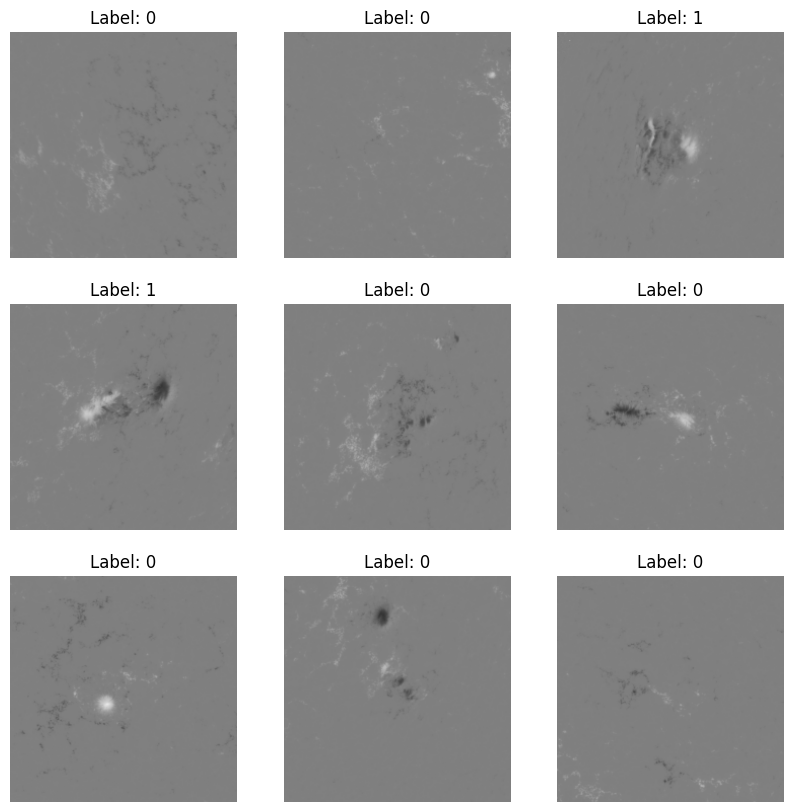

In [ ]:
for images, labels in val_dataset.take(1):
    # Since the dataset is batched, we take the first batch and display it
    display_batch_of_images(images, labels)
    break

## Final model

In [ ]:
import keras

recall = keras.metrics.Recall()
precision = keras.metrics.Precision()

In [8]:
!pip install vit-keras

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/43.5 kB 2.7 MB/s eta 0:00:00


In [9]:
import vit_keras

print (vit_keras.__version__)

0.1.2


In [10]:
!pip install tensorflow-addons

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 13.5 MB/s eta 0:00:00
  Attempting uninstall: typeguard
    Found existing installation: typeguard 4.4.1
    Uninstalling typeguard-4.4.1:
      Successfully uninstalled typeguard-4.4.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
inflect 7.4.0 requires typeguard>=4.0.1, but you have typeguard 2.13.3 which is incompatible.


In [ ]:
from vit_keras import vit

vit = vit.vit_b16(image_size=(224,224), activation="sigmoid", pretrained=True,
                            include_top=False, pretrained_top=False)

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


347502902/347502902 [==============================] - 10s 0us/step


/usr/local/lib/python3.10/dist-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 24, 24 to 14, 14
  warnings.warn(


In [ ]:
from tensorflow.keras import layers, models
from tensorflow.keras import layers, models, regularizers

for layer in vit.layers:
    layer.trainable = False

#unfreeze last layer
for layer in vit.layers[-2:]:
    layer.trainable = True

inputs = layers.Input(shape=(224, 224, 3))
x = vit(inputs)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)  #add classification head
model = models.Model (inputs, outputs)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 vit-b16 (Functional)        (None, 768)               85798656  
                                                                 
 dropout (Dropout)           (None, 768)               0         
                                                                 
 dense (Dense)               (None, 1)                 769       
                                                                 
Total params: 85799425 (327.30 MB)
Trainable params: 2305 (9.00 KB)
Non-trainable params: 85797120 (327.29 MB)
_________________________________________________________________


In [ ]:
class_weights = {0: 1.0, 1: 1.2} #have a slightly higher class weight for class 1

print (class_weights)

{0: 1.0, 1: 1.2}


In [ ]:
import keras
import tensorflow as tf

loss = tf.keras.losses.BinaryCrossentropy()

learning_rate_s = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=5, min_lr=0.000001)

optimizer = tf.keras.optimizers.AdamW(learning_rate=0.00001, weight_decay = 0.001)

model.compile (optimizer=optimizer, loss=loss, metrics=['accuracy', precision, recall])

In [ ]:
history = model.fit (dataset, validation_data = val_dataset, epochs = 20, class_weight = class_weights,
                     callbacks=[
                        tf.keras.callbacks.EarlyStopping(patience=15),
                        tf.keras.callbacks.ModelCheckpoint('/content/drive/My Drive/Thesis/best_ViT_clahe_b.keras', save_best_only=True),
                        learning_rate_s
                    ], verbose = 1)

history_df = pd.DataFrame(history.history)
history_df.to_csv('/content/drive/My Drive/Thesis/history_ViT_clahe_b.csv')

Epoch 1/20
1192/1192 [==============================] - 1462s 1s/step - loss: 0.7975 - accuracy: 0.5504 - precision: 0.5414 - recall: 0.6597 - val_loss: 0.6173 - val_accuracy: 0.6635 - val_precision: 0.6389 - val_recall: 0.7519 - lr: 1.0000e-05
Epoch 2/20
1192/1192 [==============================] - 1432s 1s/step - loss: 0.7270 - accuracy: 0.6173 - precision: 0.6045 - recall: 0.6784 - val_loss: 0.5809 - val_accuracy: 0.6942 - val_precision: 0.6739 - val_recall: 0.7523 - lr: 1.0000e-05
Epoch 3/20
1192/1192 [==============================] - 1430s 1s/step - loss: 0.6922 - accuracy: 0.6505 - precision: 0.6373 - recall: 0.6983 - val_loss: 0.5661 - val_accuracy: 0.7006 - val_precision: 0.6819 - val_recall: 0.7521 - lr: 1.0000e-05
Epoch 4/20
1192/1192 [==============================] - 1426s 1s/step - loss: 0.6771 - accuracy: 0.6662 - precision: 0.6541 - recall: 0.7055 - val_loss: 0.5574 - val_accuracy: 0.7090 - val_precision: 0.6919 - val_recall: 0.7535 - lr: 1.0000e-05
Epoch 5/20
1192/1192

## Results

In [11]:
import tensorflow as tf
import pandas as pd
import cv2
import numpy as np

dir = '/content/images_by_AR/'

#loading in images and preprocess them
def load_and_process_image_val(filename, label):
    filename = filename.decode('utf-8')
    filename = os.path.join(dir, filename)
    #image loading
    img = cv2.imread(filename)
    if img is None:
        raise ValueError(f"Image at {filename} not found.")

    #convert to rgb
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    #img = A.clahe(img, tile_grid_size=(8,8), clip_limit = 2.5)

    #normalize the image to 0, 1
    img = img.astype(np.float32) / 255.0


    return img, label

#convert these filenames and labels to np arrays to pass to the map (), because the preprocessing functions need np arrays and not tensors
def map_func_val(filename, label):
    img, label = load_and_process_image_val(filename.numpy(), label.numpy())
    return img, label

#get the filenames and labels to use in the functions created above
filenames_test = test['filename'].values
labels_test = test['class'].values

#make the datasets (turns filenames and labels to tensors)
test_dataset = tf.data.Dataset.from_tensor_slices((filenames_test, labels_test))

def process_image_and_label_val(filename, label):
    #apply the function
    img, label = tf.py_function(func=map_func_val, inp=[filename, label], Tout=[tf.float32, tf.int64])

    #set this shape because they get lost in the tf.py_function and otherwise the model cannot read the shapes
    img.set_shape([224, 224, 3])
    label.set_shape([])

    return img, label

#map the function to the dataset so everything is processed
test_dataset = test_dataset.map(process_image_and_label_val)

test_dataset = test_dataset.batch(32).prefetch(tf.data.experimental.AUTOTUNE)

In [15]:
from tensorflow.keras.models import load_model
from vit_keras import vit

model = load_model ('/content/drive/My Drive/Thesis/best_ViT_clahe_b.keras', safe_mode = False)

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [16]:
y_pred_prob = model.predict (test_dataset)

3061/3061 [==============================] - 1418s 462ms/step


In [17]:
y_pred = (y_pred_prob > 0.55).astype(int)
y_pred = y_pred.reshape(len(test),)

np.save ('/content/drive/My Drive/Thesis/y_pred_ViT_2.npy', y_pred)

In [18]:
from sklearn.metrics import classification_report, confusion_matrix

y_true = test['class'].values
print (classification_report (y_true, y_pred))


              precision    recall  f1-score   support

           0       0.92      0.73      0.81     77744
           1       0.42      0.74      0.53     20179

    accuracy                           0.73     97923
   macro avg       0.67      0.74      0.67     97923
weighted avg       0.81      0.73      0.76     97923



In [19]:
import numpy as np

def HSS (confusion_matrix):

    N = confusion_matrix.sum()
    TN = confusion_matrix[0, 0]
    TP = confusion_matrix[1, 1]
    FP = confusion_matrix[0, 1]
    FN = confusion_matrix[1, 0]

    E = ((TP + FP)*(TP + FN) + (FN + TN)*(FP + TN)) / N

    HSS = (TP + TN - E) / (N - E)

    return HSS

In [20]:
def TSS (confusion_matrix):

    TN = confusion_matrix[0, 0]
    TP = confusion_matrix[1, 1]
    FP = confusion_matrix[0, 1]
    FN = confusion_matrix[1, 0]

    TPR = TP / (TP+FN)
    TNR = TN / (TN+FP)

    TSS = (TPR + TNR) - 1

    return TSS

In [21]:
confusion = confusion_matrix (y_true, y_pred)
print (confusion)

round (HSS (confusion), 2)

[[56945 20799]
 [ 5284 14895]]


0.37

In [22]:
round (TSS (confusion),2)

0.47